In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from pathlib import Path
import torch
import wandb
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torchvision import transforms as T 


# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path(os.getcwd()).parent.parent)  
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows


/data/2_data_server/cv-07/link_dl


In [3]:
def calculate_mean_std(train_loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in tqdm(train_loader, desc='Calculating mean and std'):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    
    return mean, std

In [4]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # Load dataset with basic transform
    f_mnist_train = datasets.FashionMNIST(
        data_path, 
        train=True, 
        download=True, 
        transform=T.ToTensor()
    )
    
    f_mnist_test = datasets.FashionMNIST(
        data_path,
        train=False,
        download=True,
        transform=T.ToTensor()
    )

    # Calculate mean and std
    temp_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=1000,
        shuffle=False,
        num_workers=get_num_cpu_cores() if is_linux() or is_windows() else 0
    )
    
    mean, std = calculate_mean_std(temp_loader)
    print(f"Dataset mean: {mean.item():.4f}")
    print(f"Dataset std: {std.item():.4f}")
    
    # Split training data into train and validation sets
    f_mnist_train, f_mnist_validation = random_split(
        f_mnist_train,
        [55_000, 5_000]
    )

    print("Number of training samples:", len(f_mnist_train))
    print("Number of validation samples:", len(f_mnist_validation))
    print("Number of test samples:", len(f_mnist_test))
    
    # Set number of workers based on OS
    num_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    # num_workers = min(4, get_num_cpu_cores())  # worker 수 제한
    print("Number of Data Loading Workers:", num_workers)

    # Create data loaders
    train_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers
    )
    
    validation_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        dataset=f_mnist_test,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_workers
    )

    # Define transforms
    mnist_transforms = nn.Sequential(
        T.Resize(224),  # Resize for ResNet
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=[mean.item()], std=[std.item()])
    )

    return train_loader, validation_loader, test_loader, mnist_transforms

In [ ]:
def train_model(model, train_loader, validation_loader, mnist_transforms, epochs=50, device='cuda'):
   model = model.to(device)
   criterion = nn.CrossEntropyLoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
   scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
   
   for epoch in range(epochs):
       # Training
       model.train()
       train_loss = 0
       train_correct = 0
       train_total = 0
       
       train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{epochs}] Training',
                        bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
       
       for inputs, labels in train_pbar:
           inputs = mnist_transforms(inputs).to(device)
           labels = labels.to(device)
           
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()
           
           train_loss += loss.item()
           _, predicted = torch.max(outputs.data, 1)
           train_total += labels.size(0)
           train_correct += (predicted == labels).sum().item()
           
           train_pbar.set_postfix({
               'loss': f'{train_loss/train_total*labels.size(0):.3f}',
               'acc': f'{100.*train_correct/train_total:.2f}%',
               'lr': f'{scheduler.get_last_lr()[0]:.6f}'
           })
           
       train_loss = train_loss / len(train_loader)
       train_acc = 100. * train_correct / train_total
       
       # Validation
       model.eval()
       val_loss = 0
       val_correct = 0
       val_total = 0
       
       val_pbar = tqdm(validation_loader, desc=f'Epoch [{epoch+1}/{epochs}] Validation',
                      bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
       
       with torch.no_grad():
           for inputs, labels in val_pbar:
               inputs = mnist_transforms(inputs).to(device)
               labels = labels.to(device)
               
               outputs = model(inputs)
               loss = criterion(outputs, labels)
               
               val_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
               
               val_pbar.set_postfix({
                   'loss': f'{val_loss/val_total*labels.size(0):.3f}',
                   'acc': f'{100.*val_correct/val_total:.2f}%'
               })
       
       val_loss = val_loss / len(validation_loader)
       val_acc = 100. * val_correct / val_total
       
       print(f"Epoch [{epoch+1}/{epochs}] Results: "
             f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% "
             f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}% "
             f"--------------------")
       
       scheduler.step()

       if val_acc > 94:
           return model
       
   return model

In [17]:
import torchvision.models as models

def get_model():
    # 사전 학습된 ResNet18 로드
    model = models.resnet18(weights='IMAGENET1K_V1')
    
    # 입력 채널을 1로 수정 (Fashion MNIST는 흑백)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # 출력 레이어를 10개 클래스로 수정
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    
    return model

# 이미지 크기 조정을 위한 transform 수정
mnist_transforms = nn.Sequential(
    T.Resize(224),  # ResNet 입력 크기
    T.ConvertImageDtype(torch.float),
    T.Normalize(mean=[0.485], std=[0.229])  # 단일 채널용 정규화
)

# 문제 1, 2
Dataset mean: 0.2860
Dataset std: 0.3530

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize wandb
config={
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 8
}
# import os
# os.environ['WANDB_START_METHOD'] = 'thread'
# wandb.login()

wandb.init(
    project="fashion-mnist-resnet",
    name="resnet18",
    config=config
)

model = get_model()
train_loader, validation_loader, test_loader, mnist_transforms = get_fashion_mnist_data()
print("Training batches:", len(train_loader))
print("Validation batches:", len(validation_loader))

trained_model = train_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    mnist_transforms=mnist_transforms,
    epochs=wandb.config.epochs,
    device=device
)
wandb.finish()

cuda


Calculating mean and std: 100%|██████████| 60/60 [00:03<00:00, 17.78it/s]


Dataset mean: 0.2860
Dataset std: 0.3530
Number of training samples: 55000
Number of validation samples: 5000
Number of test samples: 10000
Number of Data Loading Workers: 64
Training batches: 1719
Validation batches: 157


Epoch [1/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.43it/s, loss=0.062, acc=90.62%]


Epoch [1/10] Results: Train Loss: 0.349 | Train Acc: 87.49% Val Loss: 0.247 | Val Acc: 90.62% --------------------


Epoch [2/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.46it/s, loss=0.058, acc=91.60%]


Epoch [2/10] Results: Train Loss: 0.232 | Train Acc: 91.71% Val Loss: 0.233 | Val Acc: 91.60% --------------------


Epoch [3/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.61it/s, loss=0.046, acc=93.26%]


Epoch [3/10] Results: Train Loss: 0.187 | Train Acc: 93.29% Val Loss: 0.184 | Val Acc: 93.26% --------------------


Epoch [4/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.91it/s, loss=0.046, acc=93.06%]


Epoch [4/10] Results: Train Loss: 0.146 | Train Acc: 94.61% Val Loss: 0.185 | Val Acc: 93.06% --------------------


Epoch [5/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.73it/s, loss=0.048, acc=93.50%]


Epoch [5/10] Results: Train Loss: 0.105 | Train Acc: 96.22% Val Loss: 0.191 | Val Acc: 93.50% --------------------


Epoch [6/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.50it/s, loss=0.047, acc=93.98%]


Epoch [6/10] Results: Train Loss: 0.058 | Train Acc: 97.89% Val Loss: 0.187 | Val Acc: 93.98% --------------------


Epoch [7/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.39it/s, loss=0.060, acc=93.82%]


Epoch [7/10] Results: Train Loss: 0.025 | Train Acc: 99.15% Val Loss: 0.239 | Val Acc: 93.82% --------------------


Epoch [8/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.85it/s, loss=0.064, acc=94.18%]


Epoch [8/10] Results: Train Loss: 0.009 | Train Acc: 99.74% Val Loss: 0.255 | Val Acc: 94.18% --------------------


Epoch [9/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.56it/s, loss=0.067, acc=94.50%]


Epoch [9/10] Results: Train Loss: 0.002 | Train Acc: 99.96% Val Loss: 0.267 | Val Acc: 94.50% --------------------


Epoch [10/10] Validation: 100%|██████████| 157/157 [00:05<00:00, 30.79it/s, loss=0.068, acc=94.66%]


Epoch [10/10] Results: Train Loss: 0.001 | Train Acc: 99.99% Val Loss: 0.271 | Val Acc: 94.66% --------------------


## Basic Parameters
- Learning Rate: 0.001
- Batch Size: 32
- Epochs: 50

## Optimization
- Optimizer: Adam
- Learning Rate Scheduler: CosineAnnealingLR
- Weight Decay: Not used
- Early Stopping: At validation accuracy ≥ 94%

## Data Processing
- Normalization: 
 - Mean: 0.2860
 - Std: 0.3530
- Input Size: 224x224 (ResNet requirement)

# 문제 3

In [20]:
# Dataset mean: 0.2860
# Dataset std: 0.3530

def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=T.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=0.2860, std=0.3530),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [21]:
torch.save(trained_model.state_dict(), "resnet18_fashion_mnist.pth")

In [27]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=T.ToTensor())
    
    # 배치 크기를 32로 변경
    test_data_loader = DataLoader(
        dataset=f_mnist_test, 
        batch_size=32,  # 전체 데이터셋 대신 32로 설정
        num_workers=4
    )
    
    f_mnist_transforms = nn.Sequential(
        T.Resize(224),  # ResNet 입력 크기에 맞게 조정
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=0.2860, std=0.3530),
    )
    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [28]:
def test_model(model, test_loader, mnist_transforms, device='cuda'):
   model.eval()
   test_correct = 0
   test_total = 0
   all_predictions = []
   
   test_pbar = tqdm(test_loader, desc='Testing',
                   bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
   
   with torch.no_grad():
       for inputs, labels in test_pbar:
           inputs = mnist_transforms(inputs).to(device)
           labels = labels.to(device)
           
           outputs = model(inputs)
           _, predicted = torch.max(outputs.data, 1)
           test_total += labels.size(0)
           test_correct += (predicted == labels).sum().item()
           all_predictions.extend(predicted.cpu().numpy())
           
           test_pbar.set_postfix({
               'acc': f'{100.*test_correct/test_total:.2f}%'
           })
   
   test_acc = 100. * test_correct / test_total
   print(f"\nTest Accuracy: {test_acc:.2f}%")
   
   return test_acc, all_predictions

In [29]:
f_mnist_test_images, test_loader, test_transforms = get_fashion_mnist_test_data()
test_accuracy, predictions = test_model(trained_model, test_loader, mnist_transforms, device)

Testing: 100%|██████████| 313/313 [00:04<00:00, 66.75it/s, acc=94.06%]


Test Accuracy: 94.06%


# 문제 4

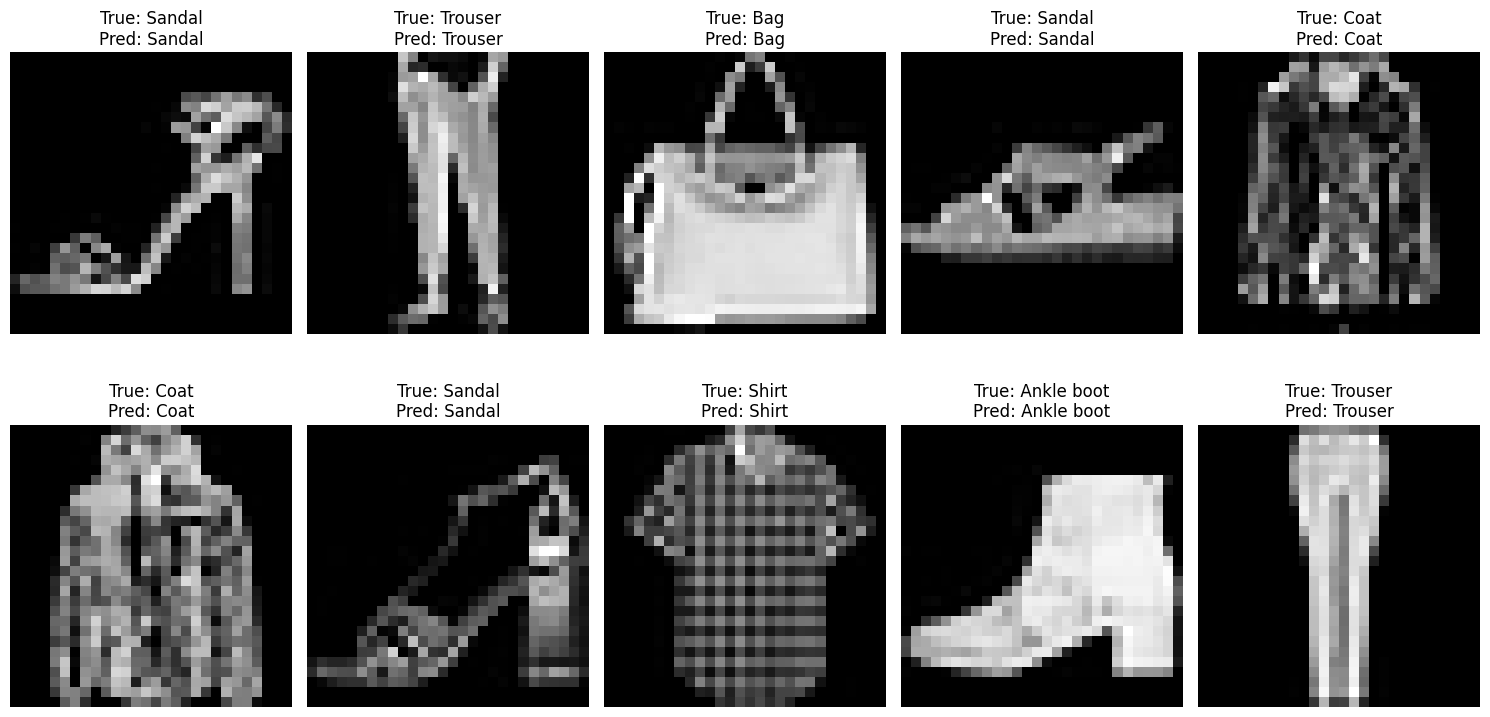

In [31]:
def visualize_test_predictions(model, test_images, test_loader, transforms, num_samples=10, device='cuda'):
   # Fashion MNIST 클래스 레이블
   classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
   
   # 랜덤 인덱스 선택
   import random
   total_samples = len(test_images)
   indices = random.sample(range(total_samples), num_samples)
   
   model.eval()
   plt.figure(figsize=(15, 8))
   
   with torch.no_grad():
       for idx, sample_idx in enumerate(indices):
           # 이미지와 레이블 가져오기
           image, label = test_images[sample_idx]
           
           # 이미지 전처리 및 예측
           image_tensor = transforms(T.ToTensor()(image).unsqueeze(0)).to(device)
           output = model(image_tensor)
           _, predicted = torch.max(output.data, 1)
           
           # 시각화
           plt.subplot(2, 5, idx + 1)
           plt.imshow(image, cmap='gray')
           plt.title(f'True: {classes[label]}\nPred: {classes[predicted.item()]}')
           plt.axis('off')
   
   plt.tight_layout()
   plt.show()

# 사용 예시
visualize_test_predictions(trained_model, f_mnist_test_images, test_loader, mnist_transforms)

In [33]:
from torchinfo import summary

summary(trained_model, input_size=(32, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│